#### Mechanics of Nearshore Setup

Last week found amount of energy efficiency by doing $H_{1,ig} / H_0$ and comparing to $T_p$. So this week, instead of focusing on how much energy is moving nearshore, it's time to think about the mechanicsms driving this energy 

**Core Question** What drives oscillations in setup? Is it the radiation stress from breaking short wave groups or the arrival of the bound IG wave?

Bound wave theory. Use complex demodulation to extract the swell envelope and compare its phase/magnitude to the measured IG signal. 

In [2]:
from scipy.io import loadmat
import sys
sys.path.append("..")
import pandas as pd
import matplotlib.pyplot as plt
from src.A_loadPressureData import loadPressureData
from src.spectra import sensor_spectra
from src.bulk_parameters import Hs_band

#### 2. Complex Demodulation of the Swell Band 

- Band-pass filter the raw signal around the swell peak
- shift the freq to zero (mult by $e^{-i2\pi f_pt }$)
- apply a low pass filter half the size of the bandwidth

In [3]:
import sys
sys.path.append("..")
import pandas as pd
import matplotlib.pyplot as plt
from src.spectra import sensor_spectra


<>:44: SyntaxWarning: invalid escape sequence '\e'
<>:44: SyntaxWarning: invalid escape sequence '\e'
/var/folders/7q/04p1sn755vg5x39skt2hykjh0000gn/T/ipykernel_72265/3584252615.py:44: SyntaxWarning: invalid escape sequence '\e'
  axes[1].set_title('Cross-Shore Water Level Gradient ($\eta$)')
/var/folders/7q/04p1sn755vg5x39skt2hykjh0000gn/T/ipykernel_72265/3584252615.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  shore_tt = aligned_n['near'] - aligned_n['near'].rolling(tt, center=True).mean()
/var/folders/7q/04p1sn755vg5x39skt2hykjh0000gn/T/ipykernel_72265/3584252615.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  far_tt = aligned_n['far'] - aligned_n['far'].rolling(tt, center=True).mean()
/var/folders/7q/04p1sn755vg5x39skt2hykjh0000gn/T/ipykernel_72265/3584252615.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
 

Peak wave event occurred around: 2008-01-13 20:15:00


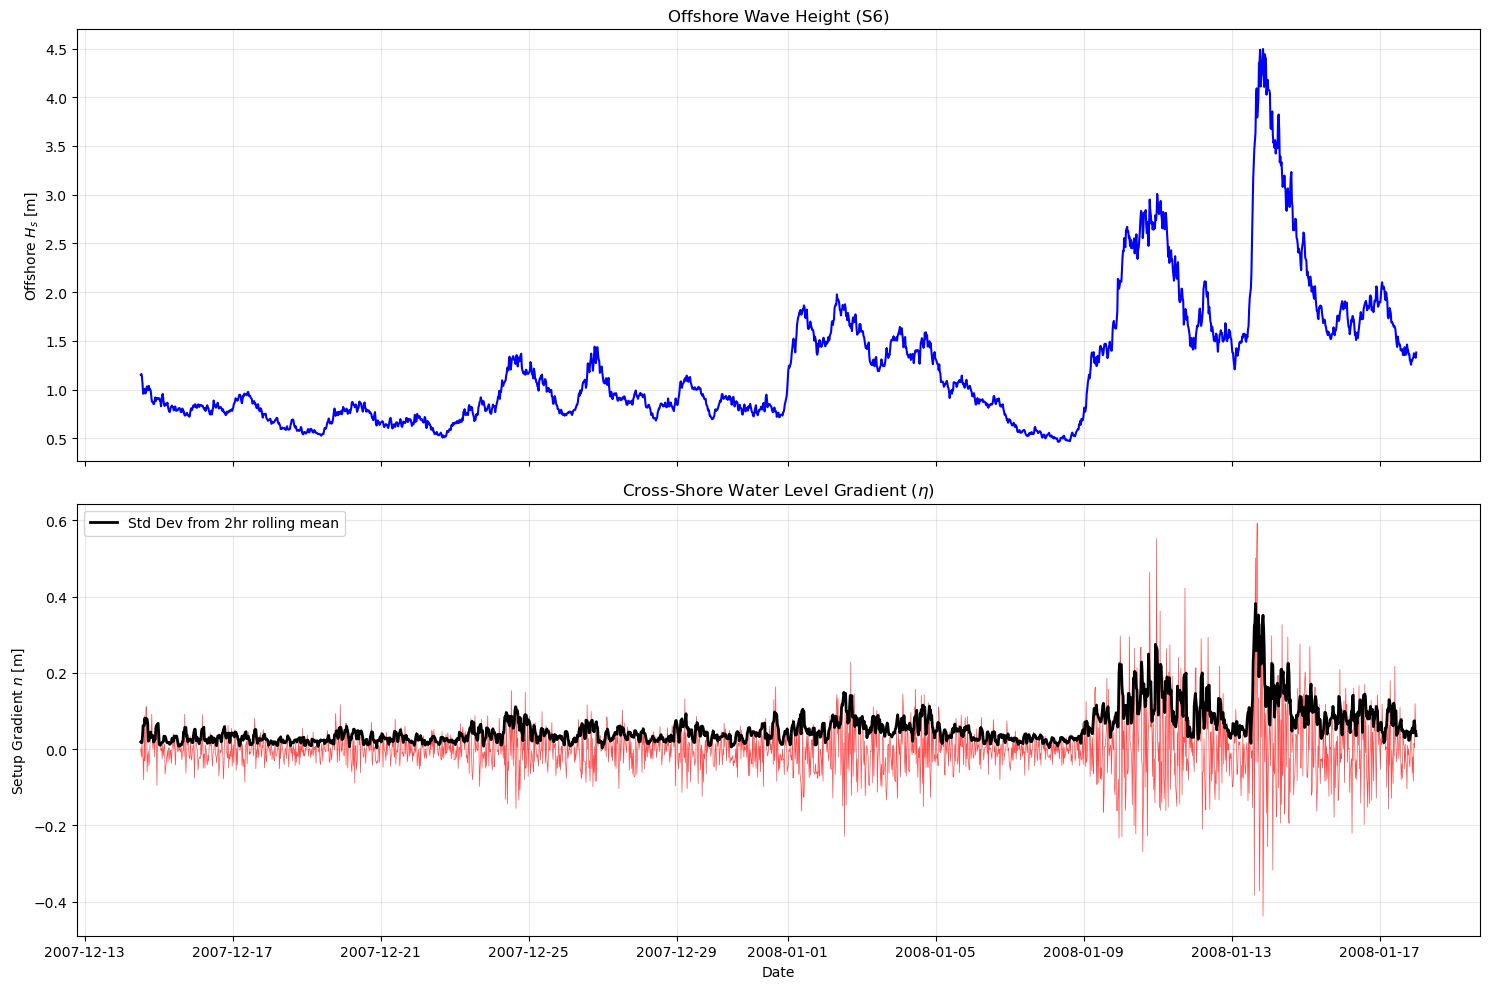

In [11]:
# ---- load data ----- #
df1 = pd.read_parquet('../data_interim/df1.parquet')
df6 = pd.read_parquet('../data_interim/df6.parquet')

## --------- compute setup ------------ ##

# 30s mean on raw data
h1_30s = df1['h'].resample('30s').mean()
h6_30s =  df6['h'].resample('30s').mean()
# time align the two sensors
aligned_n = pd.DataFrame({
    'near': h1_30s,
    'far': h6_30s
})

# instead of a global mean, using a rolling 3 hour mean to track 
# the setup more locally 
tt = '3H'
shore_tt = aligned_n['near'] - aligned_n['near'].rolling(tt, center=True).mean()
far_tt = aligned_n['far'] - aligned_n['far'].rolling(tt, center=True).mean()

n = shore_tt - far_tt

# compute Hs to find noteable swell event
hs = df6['h'].rolling('1H').std() * 4

# Match the indices for plotting
plot_data = pd.DataFrame({'Hs': hs, 'n': n}).dropna()

# 4. Create the Plot
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

axes[0].plot(plot_data.index, plot_data['Hs'], color='blue', lw=1.5)
axes[0].set_ylabel('Offshore $H_s$ [m]')
axes[0].set_title('Offshore Wave Height (S6)')
axes[0].grid(True, alpha=0.3)

# Highlight high wave events
axes[1].plot(plot_data.index, plot_data['n'], color='red', lw=0.5, alpha=0.7)
# Plot a smoothed version of n to see the magnitude of oscillations
axes[1].plot(plot_data.index, plot_data['n'].rolling('2H', center=True).std(), color='black', lw=2, label='Std Dev from 2hr rolling mean')
axes[1].set_ylabel('Setup Gradient $n$ [m]')
axes[1].set_xlabel('Date')
axes[1].set_title('Cross-Shore Water Level Gradient ($\eta$)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()

# Find the peak wave event
peak_time = plot_data['Hs'].idxmax()
print(f"Peak wave event occurred around: {peak_time}")



Notable events are the Jan 10/11 and Jan 13/14 swell 

next step is to make my complex demod script better:

In [5]:
import numpy as np
import pandas as pd
from scipy.signal import spectrogram, butter, filtfilt

# inputs from earlier celle to test out this function
start = pd.Timestamp("2008-01-13 18:00:00")
end = pd.Timestamp("2008-01-14 06:00:00")
df = df1
f_swell = (0.05, 0.2)
fenv_max = 0.004
fs = 1.
p_col='h'

# subset by time
df_win = df.loc[start:end].copy()

x = df_win[p_col].to_numpy()
t_ns = df_win.index.values.astype('datetime64[ns]').astype(np.int64)
t_sec = (t_ns - t_ns[0]) / 1e9

# find carrier frequency, f0
f, t_spec, Sxx = spectrogram(x, fs=fs, nperseg=1024, noverlap=512)
S_avg = Sxx.mean(axis=1)
mask = (f >= f_swell[0]) & (f <= f_swell[1])
f0 = f[mask][np.argmax(S_avg[mask])]

np.shape(Sxx)


(513, 83)

In [6]:
def complex_demod(
    df,
    start,
    end,
    p_col="h",
    f_swell=(0.05, 0.2), # Standard swell band
    f_env_max=0.04,      # Cutoff for the envelope (IG/Setup scale)
    fs=1.0,
):
    """
    Implements Complex Demodulation per Thomson & Emery.
    """
    # Subset by time
    df_win = df.loc[start:end].copy()
  

    x = df_win[p_col].to_numpy()
    t_ns = df_win.index.values.astype('datetime64[ns]').astype(np.int64)
    t_sec = (t_ns - t_ns[0]) / 1e9

    # 2. Spectral analysis to find carrier frequency (f0)
    f, t_spec, Sxx = spectrogram(x, fs=fs, nperseg=1024, noverlap=512)
    S_avg = Sxx.mean(axis=1)
    mask = (f >= f_swell[0]) & (f <= f_swell[1])
    f0 = f[mask][np.argmax(S_avg[mask])]

    # 3. Bandpass raw signal (isolating swell before demod)
    nyq = 0.5 * fs
    b_bp, a_bp = butter(4, [f_swell[0]/nyq, f_swell[1]/nyq], btype="band")
    x_ss = filtfilt(b_bp, a_bp, x)

    # 4. Demodulate (Shift to baseband)
    # Thomson & Emery: multiplying by exp(-i*2*pi*f0*t)
    z_raw = x_ss * np.exp(-1j * 2 * np.pi * f0 * t_sec)

    # 5. Low-pass filter (Remove 2*f0 component)
    # The bandwidth of this filter defines the "envelope" resolution
    b_lp, a_lp = butter(4, f_env_max/nyq, btype="low")
    z = filtfilt(b_lp, a_lp, z_raw)    

    # 6. Extract Physical Parameters
    # Factor of 2 scales back to physical wave amplitude
    A = 2 * np.abs(z) 
    # Wave Forcing (Radiation Stress Proxy) is proportional to A^2
    E = A**2 

    return {
        "f0": f0,
        "A": pd.Series(A, index=df_win.index),
        "E": pd.Series(E, index=df_win.index),
        "t": df_win.index
    }



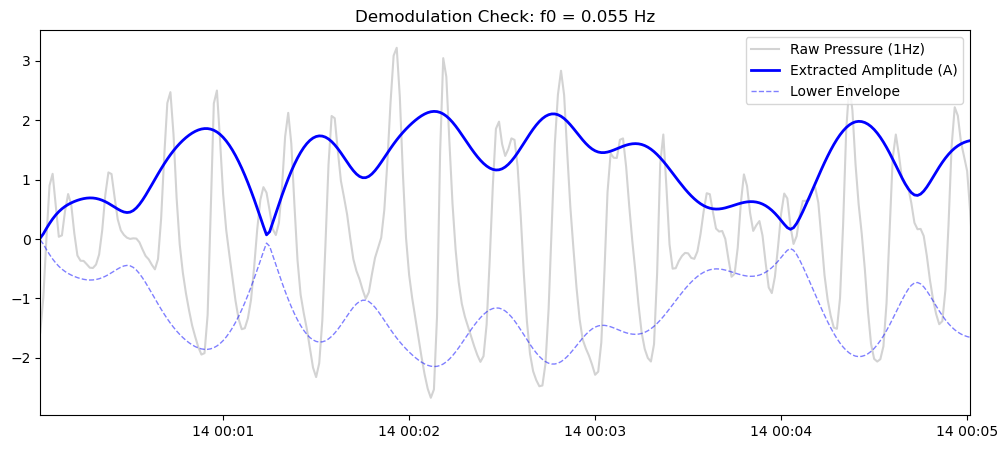

KeyError: 'x_ss'

In [7]:
complex_demod(
    df,
    start,
    end,
    p_col="h",
    f_swell=(0.05, 0.2), # Standard swell band
    f_env_max=0.04,      # Cutoff for the envelope (IG/Setup scale)
    fs=1.0,
)

# 1. Run the fixed demod on a test window
res = complex_demod(df6, "2008-01-14 00:00:00", "2008-01-14 01:00:00")

# 2. Extract components
t = res['t']
x_raw = df6.loc[t, 'h'] - df6.loc[t, 'h'].mean() # Demean for plotting
A = res['A']

# 3. Diagnostic Plot
plt.figure(figsize=(12, 5))
plt.plot(t, x_raw, color='lightgray', label='Raw Pressure (1Hz)')
plt.plot(t, A, color='blue', linewidth=2, label='Extracted Amplitude (A)')
plt.plot(t, -A, color='blue', linewidth=1, linestyle='--', alpha=0.5, label='Lower Envelope')

# Zoom in to see 5 minutes
plt.xlim(t[0], t[0] + pd.Timedelta(minutes=5))
plt.title(f"Demodulation Check: f0 = {res['f0']:.3f} Hz")
plt.legend()
plt.show()

# 4. Energy Check
var_signal = np.var(res['x_ss'])
mean_energy = np.mean(res['E']) / 2
print(f"Variance of Filtered Signal: {var_signal:.4f}")
print(f"Half of Mean Energy (A^2 / 2): {mean_energy:.4f}")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import spectrogram, butter, filtfilt

# Define the interesting window
t_start = pd.Timestamp("2008-01-13 18:00:00")
t_end = pd.Timestamp("2008-01-14 06:00:00")

# 1. Prepare Setup Gradient (n) for this window
# Re-using the logic we established: 30s means, 3H rolling demean
s1_win = df1.loc[t_start:t_end].copy()
s6_win = df6.loc[t_start:t_end].copy()


aligned_n = pd.DataFrame({'near': h1_30s, 'far': h6_30s}).dropna()
tt = '3H'
shore_fluc = aligned_n['near'] - aligned_n['near'].rolling(tt, center=True).mean()
far_fluc = aligned_n['far'] - aligned_n['far'].rolling(tt, center=True).mean()
n = (shore_fluc - far_fluc).dropna()

# 2. Complex Demodulation on Offshore Sensor (S6)
def perform_demod(series, fs=1.0, f_swell=(0.05, 0.2), f_env_max=0.04):
    x = series.values
    t_sec = (series.index.view(np.int64) - series.index[0].view(np.int64)) / 1e9
    
    # Identify dominant frequency f0
    f, Pxx = spectrogram(x, fs=fs, nperseg=1024, noverlap=512, detrend='linear')
    Pxx_avg = Pxx.mean(axis=1)
    mask = (f >= f_swell[0]) & (f <= f_swell[1])
    f0 = f[mask][np.argmax(Pxx_avg[mask])]
    
    # Bandpass filter the raw signal around the swell band
    nyq = 0.5 * fs
    b_bp, a_bp = butter(4, [f_swell[0]/nyq, f_swell[1]/nyq], btype='band')
    x_ss = filtfilt(b_bp, a_bp, x)
    
    # Shift to baseband
    carrier = np.exp(-1j * 2 * np.pi * f0 * t_sec)
    x_demod = x_ss * carrier
    
    # Lowpass to get the complex envelope
    b_lp, a_lp = butter(4, f_env_max/nyq, btype='low')
    z = filtfilt(b_lp, a_lp, x_demod)
    
    # Magnitude: factor of 2 because we shifted a real signal's positive frequency
    A = 2 * np.abs(z)
    E = A**2
    
    return pd.Series(A, index=series.index), pd.Series(E, index=series.index), f0

# Run demodulation on the 1Hz offshore data
env_A, env_E, peak_f = perform_demod(s6_win['h'])

# 3. Plotting
fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

# Panel 1: Offshore Raw and Amplitude Envelope
# Zoom into a smaller chunk for clarity (2 hours)
t_zoom_end = t_start + pd.Timedelta(hours=2)
axes[0].plot(s6_win.loc[t_start:t_zoom_end].index, s6_win['h'].loc[t_start:t_zoom_end] - s6_win['h'].loc[t_start:t_zoom_end].mean(), 
             color='lightgray', label='Offshore Raw (Swell)')
axes[0].plot(env_A.loc[t_start:t_zoom_end].index, env_A.loc[t_start:t_zoom_end], 
             color='blue', lw=2, label=f'Amplitude Envelope A (f0={peak_f:.3f}Hz)')
axes[0].set_ylabel('Amplitude [m]')
axes[0].set_title('Offshore Swell Groups (S6)')
axes[0].legend(loc='upper right')

# Panel 2: Forcing (Envelope Squared)
# Resample E to 30s to match n
env_E_30s = env_E.resample('30s').mean()
axes[1].plot(env_E_30s.loc[t_start:t_zoom_end].index, env_E_30s.loc[t_start:t_zoom_end], 
             color='darkblue', lw=2, label='Forcing Proxy ($A^2$)')
axes[1].set_ylabel('Energy [$m^2$]')
axes[1].set_title('Wave Forcing (Radiation Stress Proxy)')
axes[1].legend(loc='upper right')

# Panel 3: Response (Setup Gradient n)
axes[2].plot(n.loc[t_start:t_zoom_end].index, n.loc[t_start:t_zoom_end], 
             color='red', marker='o', markersize=4, label='Setup Gradient (n)')
axes[2].axhline(0, color='black', ls='--', alpha=0.3)
axes[2].set_ylabel('$\Delta \eta$ [m]')
axes[2].set_xlabel('Time')
axes[2].set_title('Response: Setup Oscillations')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.savefig('demod_setup_comparison.png')
print(f"Demodulation plot saved. Peak frequency found: {peak_f:.4f} Hz")

1. compute cross shore water level gradient 

2.  compute spectra
    - what is the nperseg to use?

3. perform compelx demoulation on the ss band 

4. compute bispectra 




Top 5 Swell Events:
<xarray.DataArray 'Seta' (time: 5)> Size: 40B
array([41.54795224, 40.41448579, 35.37893554, 34.37014207, 30.73709561])
Coordinates:
  * time     (time) datetime64[ns] 40B 2008-01-13T20:45:00.417424384 ... 2008...


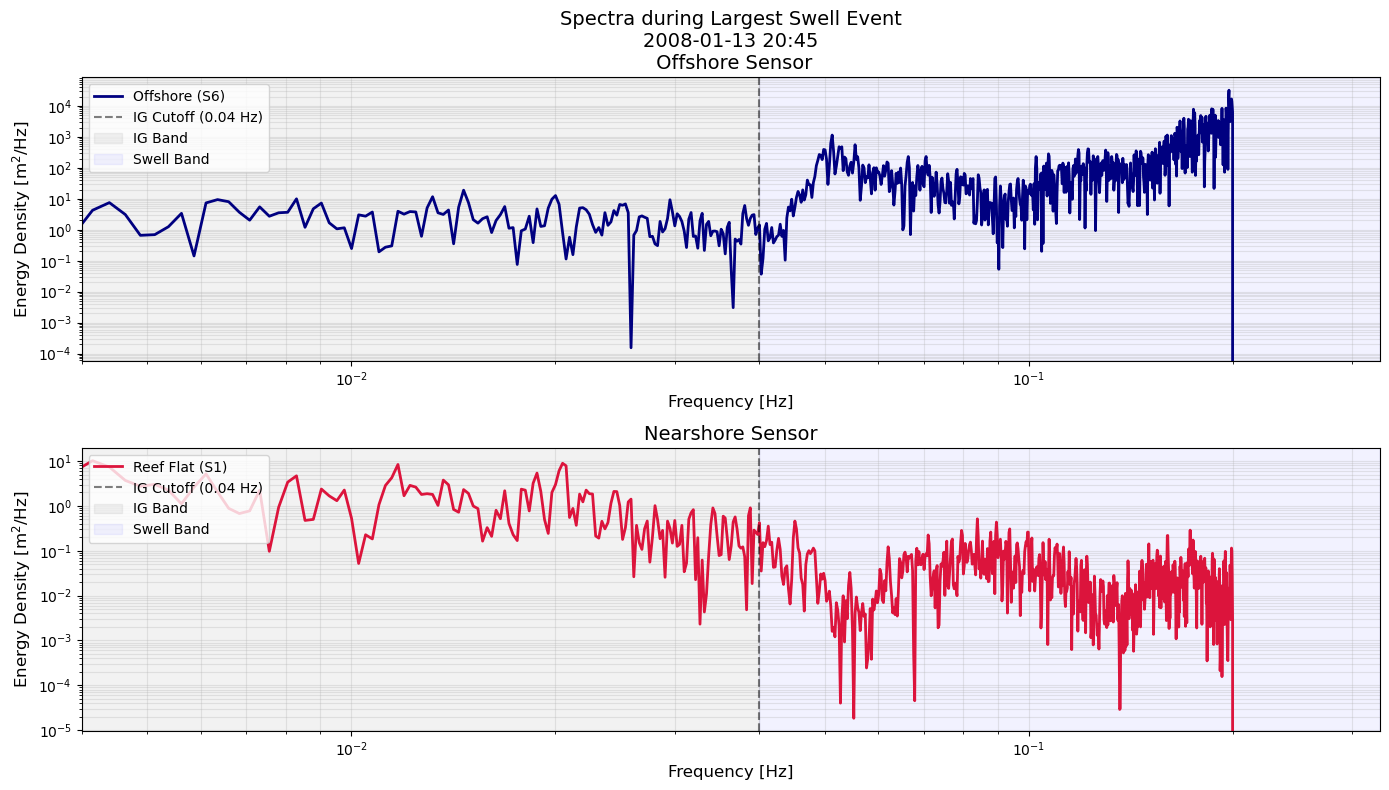

In [ ]:
hs_s6 = Hs_band(S6, fmin=0.04, fmax=0.33)
print("\nTop 5 Swell Events:")
print(hs_s6.sortby(hs_s6, ascending=False).head(time=5))

t_max = hs_s6.idxmax(dim="time")
hs_max_val = hs_s6.sel(time=t_max).item()

spec6 = S6['Seta'].sel(time=t_max, method='nearest')
spec1 = S1['Seta'].sel(time=t_max, method='nearest')


# 4. Plot the spectra
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(14, 8))

# Log-log plot is standard for viewing IG and Swell bands together
ax1.loglog(spec6.frequency, spec6, label='Offshore (S6)', color='navy', linewidth=2)

# Add visual guides for frequency bands
ax1.axvline(0.04, color='k', linestyle='--', alpha=0.5, label='IG Cutoff (0.04 Hz)')
ax1.axvspan(0.004, 0.04, color='gray', alpha=0.1, label='IG Band')
ax1.axvspan(0.04, 0.33, color='blue', alpha=0.05, label='Swell Band')

# Formatting
ax1.set_xlabel('Frequency [Hz]', fontsize=12)
ax1.set_ylabel('Energy Density [m$^2$/Hz]', fontsize=12)
ax1.set_title(f'Spectra during Largest Swell Event\n{pd.to_datetime(t_max.values).strftime("%Y-%m-%d %H:%M")}\n Offshore Sensor', fontsize=14)
ax1.legend(loc='upper left')
ax1.grid(True, which="both", alpha=0.3)
ax1.set_xlim(0.004, 0.33)  # Focus on relevant frequencies (IG + Swell)

ax2.loglog(spec1.frequency, spec1, label='Reef Flat (S1)', color='crimson', linewidth=2)
ax2.axvline(0.04, color='k', linestyle='--', alpha=0.5, label='IG Cutoff (0.04 Hz)')
ax2.axvspan(0.004, 0.04, color='gray', alpha=0.1, label='IG Band')
ax2.axvspan(0.04, 0.33, color='blue', alpha=0.05, label='Swell Band')

ax2.set_xlabel('Frequency [Hz]', fontsize=12)
ax2.set_ylabel('Energy Density [m$^2$/Hz]', fontsize=12)
ax2.set_title(f'Nearshore Sensor', fontsize=14)
ax2.legend(loc='upper left')
ax2.grid(True, which="both", alpha=0.3)
ax2.set_xlim(0.004, 0.33)  # Focus on relevant frequencies (IG + Swell)

plt.tight_layout()
plt.show()



TypeError: sensor_spectra() got an unexpected keyword argument 'f_cutoff'

#### 3. Bispectra/Biphase analysis

- use bispectrum to quantify the phase coupling between two short waves and the resulting IG waves
- compute the biphase to see the angular offset
    - if $\beta$ ~ 180 degrees: bound wave theory holds
    - if $\beta$ ~ 90 degrees: waves are in strong shaoling/nonlinear transition. 


#### 4. If there's time:
a. **groupiness** Does higher groupiness offshore lead to higher efficiency nearshore? Compute the GF (groupiness factor)

b. **lag analysis** do cross correlation between offshore envelope and nearshore IG seignal. The time lag at peak corr should match $c_g$ from offshore sensor to the beach